<a href="https://colab.research.google.com/github/Bobbyorr007/Image-Segmentation/blob/main/IMAGE_SEGMENTATION_WITH_MASK_RCNN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3451, done.
remote: Counting objects: 100% (3451/3451), done.
remote: Compressing objects: 100% (2890/2890), done.
remote: Total 3451 (delta 891), reused 1397 (delta 504), pack-reused 0
Receiving objects: 100% (3451/3451), 46.92 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (891/891), done.


In [2]:
# Compile the Object Detection API protocol buffers
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [3]:
%%writefile models/research/setup.py

import os
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'tf-models-official==2.7.0',
    'tensorflow_io'
]

setup(
    name='object_detection',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    include_package_data=True,
    packages=(
        [p for p in find_packages() if p.startswith('object_detection')] +
        find_packages(where=os.path.join('.', 'slim'))),
    package_dir={
        'datasets': os.path.join('slim', 'datasets'),
        'nets': os.path.join('slim', 'nets'),
        'preprocessing': os.path.join('slim', 'preprocessing'),
        'deployment': os.path.join('slim', 'deployment'),
        'scripts': os.path.join('slim', 'scripts'),
    },
    description='Tensorflow Object Detection Library',
    python_requires='>3.6',
)

Writing models/research/setup.py


In [4]:
# Run the setup script you just wrote
!python -m pip install models/research

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 1.8 MB 8.8 MB/s 
     |████████████████████████████████| 25.9 MB 74.4 MB/s 
     |████████████████████████████████| 238 kB 60.4 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 116 kB 45.0 MB/s 
     |████████████████████████████████| 1.3 MB 45.1 MB/s 
     |████████████████████████████████| 352 kB 42.9 MB/s 
     |████████████████████████████████| 1.1 MB 47.8 MB/s 
     |████████

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

tf.get_logger().setLevel('ERROR')

%matplotlib inline

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = (image.size)
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


# dictionary with image tags as keys, and image paths as values
TEST_IMAGES = {
    # By Johnbrainyvisuals (OgedengbeTobi John), SOURCE: https://commons.wikimedia.org/wiki/File:Marina_road_leading_to_uba_house,_lagos,_Nigeria.jpg
    'Street' : 'https://upload.wikimedia.org/wikipedia/commons/b/b5/Marina_road_leading_to_uba_house%2C_lagos%2C_Nigeria.jpg'
}
  
  

In [7]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [8]:
# This will take 10 to 15 minutes to finish
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


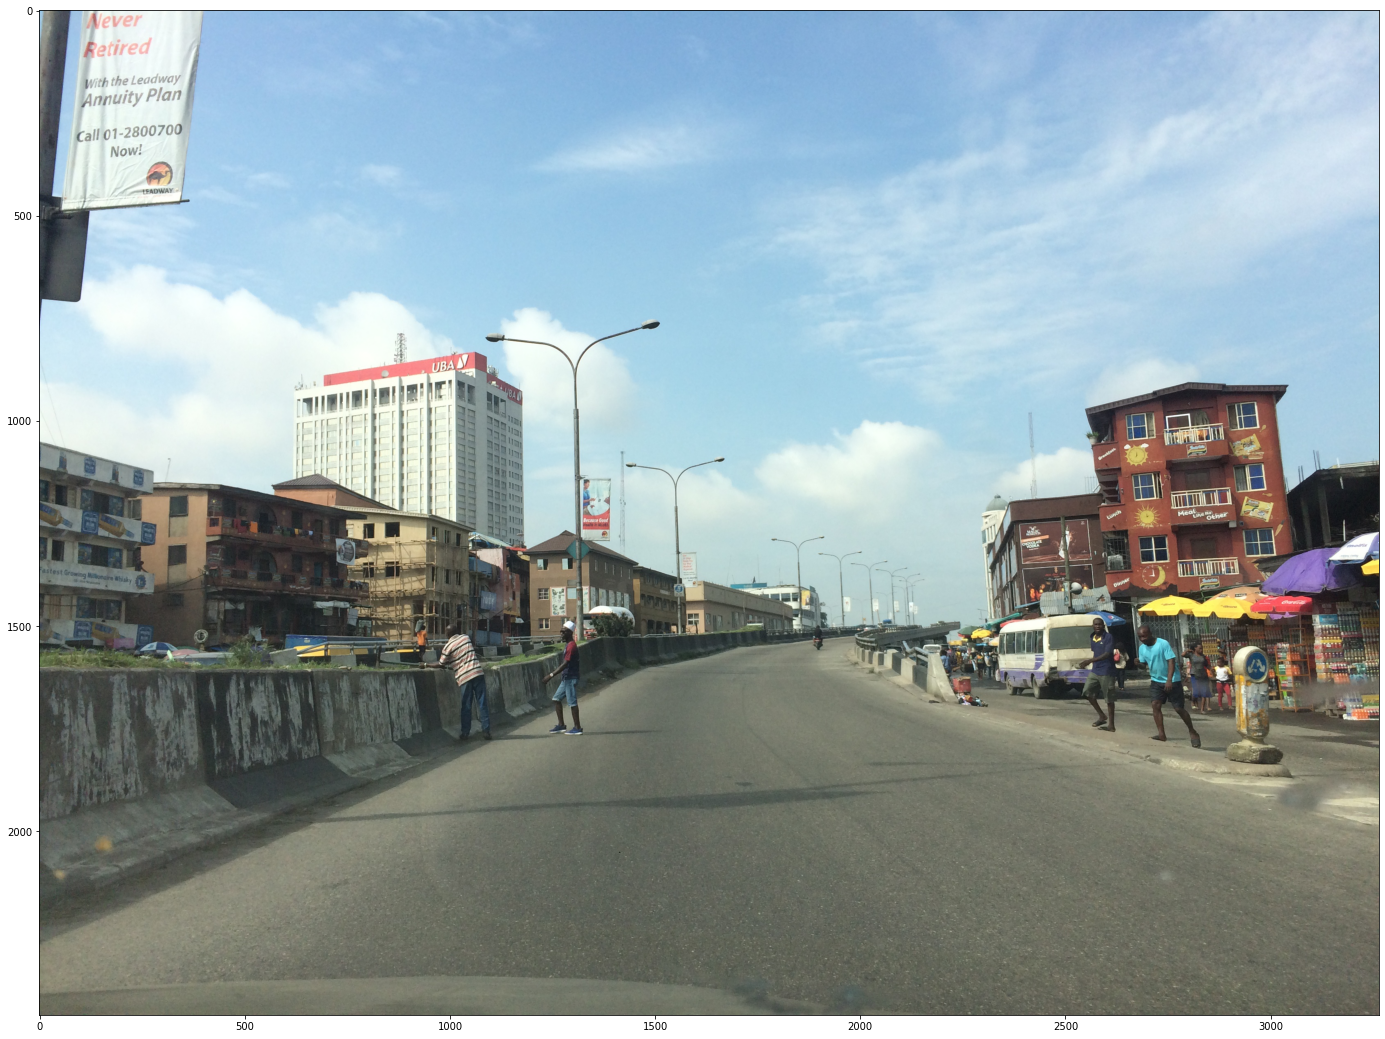

In [9]:
# Choose one and use as key for TEST_IMAGES below: 
# ['Beach', 'Street', 'Dogs','Phones']

image_path = TEST_IMAGES['Street']

image_np = load_image_into_numpy_array(image_path)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [10]:
# run inference
results = hub_model(image_np)

# output values are tensors and we only need the numpy() 
# parameter when we visualize the results
result = {key:value.numpy() for key,value in results.items()}

# print the keys
for key in result.keys():
  print(key)

rpn_box_predictor_features
rpn_objectness_predictions_with_background
detection_masks
raw_detection_scores
detection_scores
rpn_box_encodings
num_detections
image_shape
final_anchors
rpn_features_to_crop
proposal_boxes
proposal_boxes_normalized
detection_classes
detection_multiclass_scores
detection_anchor_indices
num_proposals
mask_predictions
raw_detection_boxes
box_classifier_features
detection_boxes
refined_box_encodings
anchors
class_predictions_with_background


In [11]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# sample output
print(category_index[1])
print(category_index[2])
print(category_index[4])

{'id': 1, 'name': 'person'}
{'id': 2, 'name': 'bicycle'}
{'id': 4, 'name': 'motorcycle'}


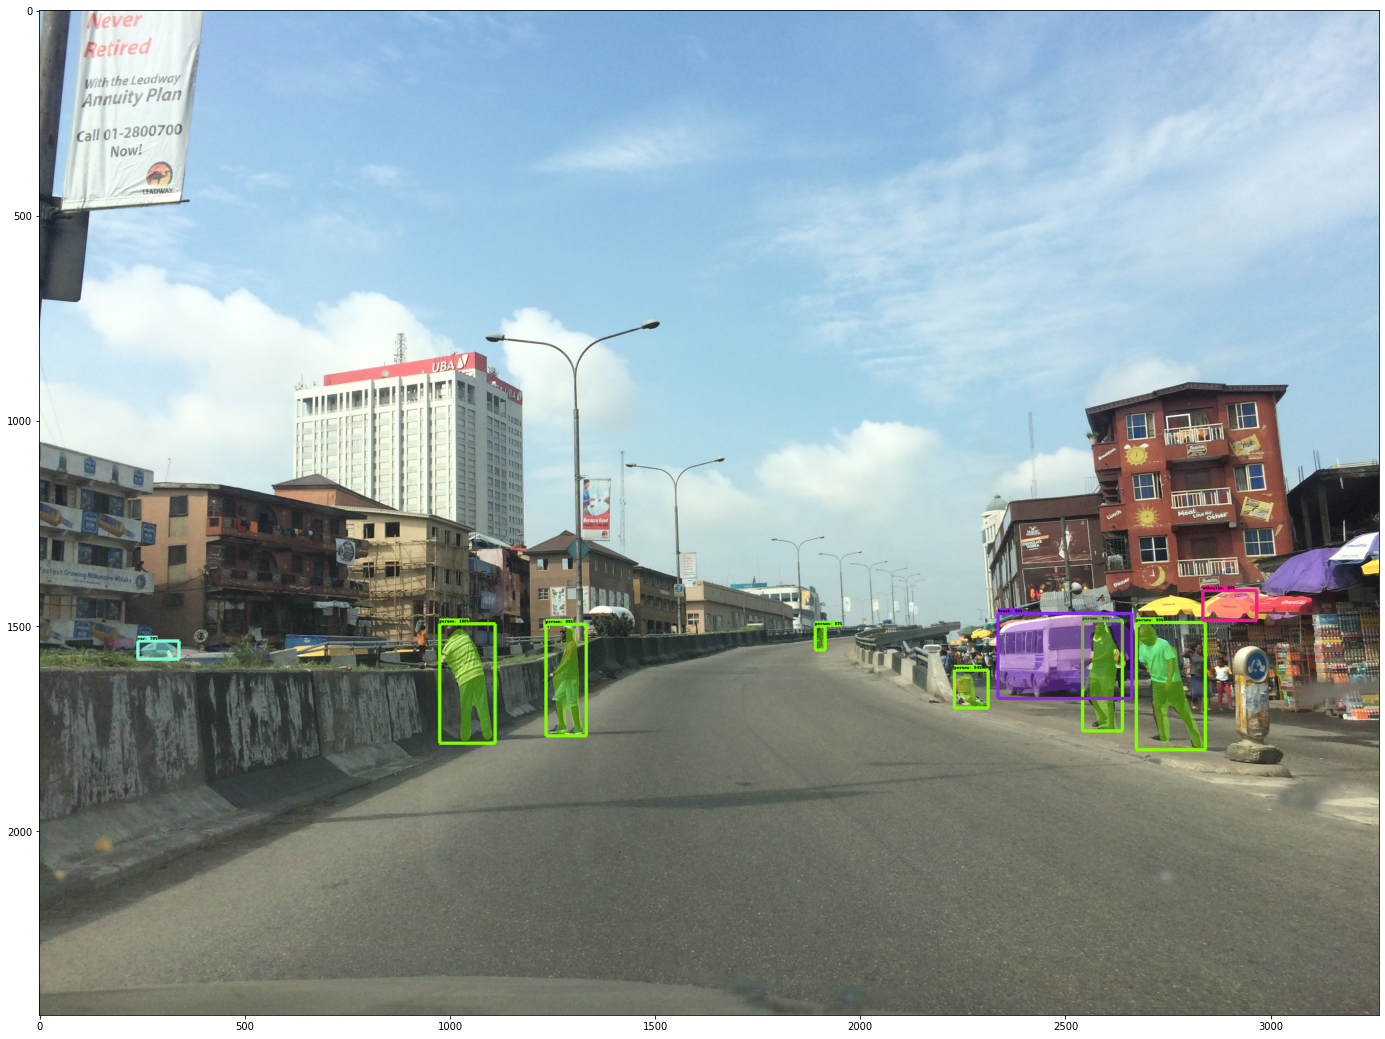

In [12]:
# Handle models with masks:
label_id_offset = 0
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:

  # convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # reframe the the bounding box mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])

  # filter mask pixel values that are above a specified threshold
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.6,
                                      tf.uint8)
  
  # get the numpy array
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

# overlay labeled boxes and segmentation masks on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.70,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()